In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner
import tensorflow as tf
import matplotlib.pyplot as plt

from modAL.uncertainty import margin_sampling
import os
from keras import backend as K
import time
import random
import pandas as pd
import cv2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#tf.logging.set_verbosity(tf.logging.ERROR)

In [48]:
# Create keras conv2D and output layer

def create_keras_model():
    model = Sequential()
    model.add(Conv2D(128, (16, 16), activation='relu'))
    model.add(Conv2D(128, (16, 16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

# load the file
def load_data(filename, nb_instance, all_instance):
  n = all_instance #number of records in file
  s = nb_instance #sample size
  skip = sorted(random.sample(range(1,n+1),n-s))

  #df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  df = pd.read_csv(filename,sep="\t",skiprows=skip)

  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  df.describe()
  return df

# read, resize and flatten into 1-dimension array
def pre_process_image(data):
  img_arr = []
  for index,row in data.iterrows():
    read_img = cv2.imread(row['image'],0)
    img_resize = cv2.resize(read_img,(32,32))
    #img_ravel = img_resize.ravel()
    img_arr.append(img_resize)

  img_np = np.array(img_arr)

  return img_np

In [22]:
def random_sampling(classifier, X,
                     n_instances: int = 1, random_tie_break: bool = False):
    
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    
    return query_idx, X[query_idx]

In [49]:
# Load CrisisMMD dataset

start_time = time.time()

#train_instance = 9601
#test_instance = 1534

all_train_instance = 9601
all_test_instance = 1534

# Use 20 % amount of data for initial phase
train_instance = 1920
test_instance = 306

train_filename = "data/task_data/task_informative_text_img_agreed_lab_train.tsv"
test_filename = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"

data_train = load_data(train_filename,train_instance, all_train_instance)
data_images_train = pre_process_image(data_train)

data_test = load_data(test_filename,test_instance, all_test_instance)
data_image_test = pre_process_image(data_test)

#X_train = data_images_train.reshape(train_instance,-1)
X_train = data_images_train
y_train = data_train['label_image_code'].values

#X_test = data_image_test.reshape(test_instance,-1)
X_test = data_image_test
y_test = data_test['label_image_code'].values

final_time = time.time() - start_time

print(final_time)

9.60716962814331


In [50]:
X_train = X_train.reshape(train_instance, 32, 32, 1).astype('float32') / 255.
X_test = X_test.reshape(test_instance, 32, 32, 1).astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1920, 32, 32, 1)
(306, 32, 32, 1)
(1920, 2)
(306, 2)


In [52]:
# initial_idx = np.array([],dtype=np.int32)
# for i in range(2):
#     idx = np.random.choice(np.where(y_train[:,i]==1)[0], size=2, replace=False)
#     initial_idx = np.concatenate((initial_idx, idx))


n_initial = 200
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [53]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [54]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              epochs=50,
                              batch_size=128,
                              n_queries=50,
                              n_instances=10,
                              verbose=0):
    start_time = time.time()
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                            verbose=verbose
                           )
    perf_hist = [learner.score(X_test, y_test, verbose=verbose)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx], epochs=epochs, batch_size=batch_size, verbose=verbose)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test, verbose=0)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
        
    final_time = time.time() - start_time
    print(final_time)
    
    return perf_hist

In [55]:
K.clear_session()
estimator = KerasClassifier(create_keras_model)

In [56]:
margin_perf_hist = active_learning_procedure(margin_sampling,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,
                                              epochs=6,
                                              verbose=1,)

10/10 [==============================] - 1s 77ms/step - loss: 0.7237 - accuracy: 0.6863
Epoch 1/6
2/2 [==============================] - 1s 308ms/step - loss: 1.1007 - accuracy: 0.5238
Epoch 2/6
2/2 [==============================] - 1s 305ms/step - loss: 0.9120 - accuracy: 0.4000
Epoch 3/6
2/2 [==============================] - 1s 310ms/step - loss: 0.6905 - accuracy: 0.6619
Epoch 4/6
2/2 [==============================] - 1s 301ms/step - loss: 0.6898 - accuracy: 0.6190
Epoch 5/6
2/2 [==============================] - 1s 303ms/step - loss: 0.6854 - accuracy: 0.6714
Epoch 6/6
2/2 [==============================] - 1s 310ms/step - loss: 0.6822 - accuracy: 0.6667
Accuracy after query 1: 0.6863
Epoch 1/6
2/2 [==============================] - 1s 359ms/step - loss: 1.8964 - accuracy: 0.6318
Epoch 2/6
2/2 [==============================] - 1s 358ms/step - loss: 0.7458 - accuracy: 0.5864
Epoch 3/6
2/2 [==============================] - 1s 355ms/step - loss: 0.6908 - accuracy: 0.5409
Epoch 4/

Text(0.5, 1.0, 'Validation Accuracy')

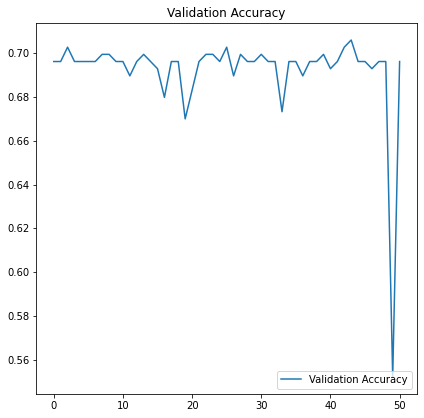

In [44]:
acc = margin_perf_hist

queries_range = range(51)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(queries_range, acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

In [45]:
random_perf_hist = active_learning_procedure(random_sampling,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,
                                              epochs=6,
                                              verbose=1,)

10/10 [==============================] - 0s 45ms/step - loss: 0.6445 - accuracy: 0.6961
Epoch 1/6
2/2 [==============================] - 1s 259ms/step - loss: 4.6641 - accuracy: 0.6429
Epoch 2/6
2/2 [==============================] - 1s 258ms/step - loss: 0.8962 - accuracy: 0.6333
Epoch 3/6
2/2 [==============================] - 1s 265ms/step - loss: 0.6911 - accuracy: 0.7143
Epoch 4/6
2/2 [==============================] - 1s 257ms/step - loss: 0.6467 - accuracy: 0.7095
Epoch 5/6
2/2 [==============================] - 1s 255ms/step - loss: 0.6610 - accuracy: 0.7095
Epoch 6/6
2/2 [==============================] - 1s 262ms/step - loss: 0.6276 - accuracy: 0.7048
Accuracy after query 1: 0.6961
Epoch 1/6
2/2 [==============================] - 1s 275ms/step - loss: 1.6211 - accuracy: 0.5000
Epoch 2/6
2/2 [==============================] - 1s 283ms/step - loss: 0.6928 - accuracy: 0.5727
Epoch 3/6
2/2 [==============================] - 1s 284ms/step - loss: 0.6487 - accuracy: 0.6864
Epoch 4/

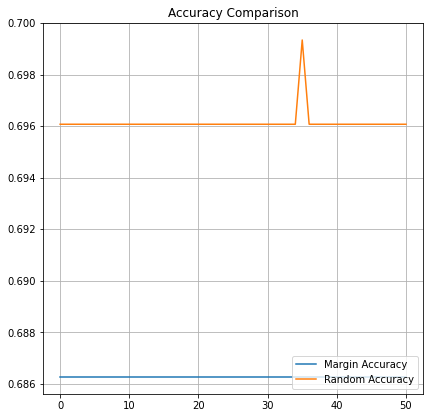

In [57]:
acc_margin = margin_perf_hist
acc_random = random_perf_hist

queries_range = range(51)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(queries_range, acc_margin, label='Margin Accuracy')
plt.plot(queries_range, acc_random, label='Random Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Comparison')
plt.grid()
plt.show()
